# Movie Recommendation

In this notebook, we will create a movie recommendation algorithm from a movie dataset using multiple methods. We demonstrates how to preprocess text data and show two approaches to using Machine Learning (ML in order to make movie recommendations. You will use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset), which contains over 45,000 movies and 26 million ratings from over 270,000 users. These are movies released in and before July 2017.

We will use different methods of preprocessing and different ML methods in order to predict movies.

This notebook is part of my [ML series](https://github.com/bryanlusse/ml-projects).

&copy; Bryan Lusse - 2022

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import sklearn
import random
import os

# Progress bars
from tqdm.auto import tqdm
tqdm.pandas()

# Text cleaning
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
# Initializing of word lists
stop_words = set(stopwords.words('english'))
words = set(words.words())

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# Models
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import dump

# Evaluation
from surprise.accuracy import rmse

# Other
from collections import defaultdict

# Inits
class color:
    BOLD = '\033[1m'
    END = '\033[0m'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
data_path = '/content/gdrive/My Drive/movie-recommendation'

if data_path.startswith('/content/gdrive/'):
    from google.colab import drive
    assert data_path.startswith('/content/gdrive/My Drive/'), 'Google Drive paths must start with "/content/gdrive/My Drive/"!'
    drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
    from google.colab import auth
    auth.authenticate_user()

Mounted at /content/gdrive


## Load data
The data is saved as multiple CSV files. First, we will pay attention to the *metadata* file.
We see that per movie, a lot of data is present.

In [3]:
metadata_df = pd.read_csv(data_path+'/'+'data/movies_metadata.csv')
display(metadata_df.head())
print(metadata_df.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


(45466, 24)


The following are all column names that are available

In [4]:
metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

More data surrounding the movies is present in other files. Information about the cast can be found in the *credits* file.

In [5]:
credits_df = pd.read_csv(data_path+'/'+'data/credits.csv')
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


Another interesting source of data is the *keywords* file. This consists of keywords regarding the story and themes of the movie. An important feature when finding similarities in movies.

In [6]:
keywords_df = pd.read_csv(data_path+'/'+'data/keywords.csv')
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## Exploratory Data Analysis

In [7]:
genres = []

for index, row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
    genre = eval(row['genres'])
    for i in range(len(genre)):
        genre_name = genre[i]['name']
        if genre_name in genres:
            pass
        else:
            genres.append(genre_name)
print('List of all genres:')
print(genres)

  0%|          | 0/45466 [00:00<?, ?it/s]

List of all genres:
['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Carousel Productions', 'Vision View Entertainment', 'Telescene Film Group Productions', 'Aniplex', 'GoHands', 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']


## Different Approaches
Recommending similar data (in this case movies), can be done through mainly two different approaches.

- **Content-based Filtering:**
    Here, the content is compared and filtered by the degree of similarity. In the case of movie recommendations, movies are compared to each other in order to find similar movies. After you have just watched a movie, Netflix might show you movies that are similar (similar genre or actors). As the filtering on similarity is done using the movies and their content, this is content-based filtering. 
    

- **Collaborative Filtering:**
    In this approach, the comparison is made between viewers rather than between movies. If two people, person A and person B, watch similar movies, their tastes in movies might be similar. So, if person A watches and likes a movie that person B has not yet seen, it makes sense to recommend this movie to person B. This might happen when you open Netflix. Recommendations are based on the watch patterns of likeminded individuals (although these are probably also based on the movies you have watched).
    
In the image below you can see an example of both content-based and collaborative clustering on books.

![Image](https://drive.google.com/uc?export=view&id=1xzPFyvGlmFR7GSF773iF8saxIt_CLEh-)

[Image Source](https://www.springboard.com/blog/data-science/recommendation-system-python/)

## Method 1: Finding Similar Movies (Content-based Filtering)

### Preprocessing
For this approach we want to combine all data that can tell us if movies are similar. From there we select the data we need and vectorize all text data.

In [8]:
for index, row in metadata_df.iterrows():
    if len(row['id'].split('-')) == 1:
        pass
    else:
        metadata_df.drop(index, inplace=True)

In [9]:
metadata_df = metadata_df.astype({'id': 'int64'})
print(metadata_df.shape)

(45463, 24)


In [10]:
tot_df = metadata_df.merge(credits_df,on='id')
tot_df = tot_df.merge(keywords_df, on='id')

In [11]:
tot_df = tot_df[['id', 'title', 'genres', 'keywords', 'cast']]

In [12]:
display(tot_df.head())
print(tot_df.shape)

,id,title,genres,keywords,cast
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '..."


(46628, 5)


We can see that in this merged dataset there are many duplicates. Duplicate movies will only worsen the recommendations of our model, therefore lets remove them:

In [13]:
tot_df[tot_df['title'].duplicated()]

,id,title,genres,keywords,cast
677,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 7059, 'name': 'anti-communism'}, {'id'...","[{'cast_id': 5, 'character': 'Sophie II', 'cre..."
678,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 7059, 'name': 'anti-communism'}, {'id'...","[{'cast_id': 5, 'character': 'Sophie II', 'cre..."
679,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 7059, 'name': 'anti-communism'}, {'id'...","[{'cast_id': 5, 'character': 'Sophie II', 'cre..."
680,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 7059, 'name': 'anti-communism'}, {'id'...","[{'cast_id': 5, 'character': 'Sophie II', 'cre..."
681,105045,The Promise,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'id': 7059, 'name': 'anti-communism'}, {'id'...","[{'cast_id': 5, 'character': 'Sophie II', 'cre..."
...,...,...,...,...,...
46583,52103,Pickpocket,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...","[{'id': 10183, 'name': 'independent film'}]","[{'cast_id': 3, 'character': 'Xiao Wu', 'credi..."
46615,404604,Mom,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'id': 155794, 'name': 'physical abuse'}, {'i...","[{'cast_id': 1, 'character': 'Devki Sabarwal',..."
46616,420346,The Morning After,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",[],"[{'cast_id': 0, 'character': 'Lauren', 'credit..."
46622,30840,Robin Hood,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",[],"[{'cast_id': 1, 'character': 'Sir Robert Hode'..."


In [14]:
tot_df = tot_df.drop_duplicates(subset=['title'])
print(tot_df.shape)
print('We removed', 46628-tot_df.shape[0], 'Movies')

(42277, 5)
We removed 4351 Movies


At this point we have cleaned the movies, but the features themselves still need to be processed and cleaned.

To do this, we need to extract each genre, keyword and cast member for the dictionaries that are present in the data. Additionally, the text data itself needs to be processed. Because this is a basic dataset consisting of separate words and not an intriquete text document, we do not need to employ multiple processing methods.

- The main method is **Removing punctuation and capitals**:

    It is easier for our model to not have to worry about punctuation. With added punctuation similar words will have to be encoded as having a different meaning -> 'hello' will not be the same as 'hello!'. In order to keep the data easier for our model, we remove punctuation. 
    
The function below does exactly this for all columns:

In [15]:
def cleanText(txt):
    """
    Cleans text data saved as dictionary by extracting the values corresponding to the key 'name'.
    Removes spaces and capitalization.
    
    Args:
        txt: Dictionary saved as string
    Returns:
        All values with key 'name' OR empty string if input is NaN
    """
    if pd.isna(txt):
        return ''
    txt_dict = eval(txt)
    names = []

    for pair in txt_dict:
        for key in pair:
            if key == 'name':
                names.append(str.lower(pair[key].replace(' ', '')))
    txt = " ".join(names)
    
    return txt

In [16]:
# Clean features per column
features = ['genres', 'keywords', 'cast']

for feature in features:
    tot_df[feature] = tot_df[feature].apply(cleanText)

The cleaned dataset now looks like the following:

In [17]:
display(tot_df.head())
print(tot_df.shape)

,id,title,genres,keywords,cast
0,862,Toy Story,animation comedy family,jealousy toy boy friendship friends rivalry bo...,tomhanks timallen donrickles jimvarney wallace...
1,8844,Jumanji,adventure fantasy family,boardgame disappearance basedonchildren'sbook ...,robinwilliams jonathanhyde kirstendunst bradle...
2,15602,Grumpier Old Men,romance comedy,fishing bestfriend duringcreditsstinger oldmen,waltermatthau jacklemmon ann-margret sophialor...
3,31357,Waiting to Exhale,comedy drama romance,basedonnovel interracialrelationship singlemot...,whitneyhouston angelabassett lorettadevine lel...
4,11862,Father of the Bride Part II,comedy,baby midlifecrisis confidence aging daughter m...,stevemartin dianekeaton martinshort kimberlywi...


(42277, 5)


In the next step, we want to remove entries with an empty title. We make a choice to keep entries with empty genres, keywords, or cast.

In [18]:
# Remove rows with emnpty title
nan_value = float("NaN")
tot_df.replace("", nan_value, inplace=True) # Replace all empty values with NaN values in order to drop
tot_df.dropna(subset = ['title'], inplace=True)
tot_df.replace(nan_value, "", inplace=True) # Replace all remaining NaN values with empty values as we were only concerned with empty titles, not empty keywords
print(tot_df.shape)

(42276, 5)


At this moment we will not be removing any data anymore, therefore it is a good time to redefine the ID's of all our movies.

In [19]:
tot_df['id'] = range(len(tot_df))

Finally, we combine all features into one column that will represent the whole movie.

In [20]:
def createCombined(df):
    """
    Combines multiple columns from a dataframe 'df' seperated by spaces.
    
    Args:
        df: Pandas DataFrame
    Returns:
        Pandas Series
    """
    return df['genres'] + ' ' + df['keywords'] + ' ' + df['cast']

tot_df["combined"] = tot_df.apply(createCombined, axis=1)
tot_df["combined"].head()

0    animation comedy family jealousy toy boy frien...
1    adventure fantasy family boardgame disappearan...
2    romance comedy fishing bestfriend duringcredit...
3    comedy drama romance basedonnovel interracialr...
4    comedy baby midlifecrisis confidence aging dau...
Name: combined, dtype: object

In [21]:
tot_df.head()

,id,title,genres,keywords,cast,combined
0,0,Toy Story,animation comedy family,jealousy toy boy friendship friends rivalry bo...,tomhanks timallen donrickles jimvarney wallace...,animation comedy family jealousy toy boy frien...
1,1,Jumanji,adventure fantasy family,boardgame disappearance basedonchildren'sbook ...,robinwilliams jonathanhyde kirstendunst bradle...,adventure fantasy family boardgame disappearan...
2,2,Grumpier Old Men,romance comedy,fishing bestfriend duringcreditsstinger oldmen,waltermatthau jacklemmon ann-margret sophialor...,romance comedy fishing bestfriend duringcredit...
3,3,Waiting to Exhale,comedy drama romance,basedonnovel interracialrelationship singlemot...,whitneyhouston angelabassett lorettadevine lel...,comedy drama romance basedonnovel interracialr...
4,4,Father of the Bride Part II,comedy,baby midlifecrisis confidence aging daughter m...,stevemartin dianekeaton martinshort kimberlywi...,comedy baby midlifecrisis confidence aging dau...


### Vectorization
The initial set of raw data has currently been reduced to a more manageable dataset. From here, another step is necessary. We need a method to transform the data from textual to numerical, and this is where vectorization comes in.

Vectorization turns a piece of text into a vector containing numbers. There are many different methods to do this.
From here on, we explain four different methods to perform vectorization:

#### Bag-of-Words
This method is simple and flexible, and it can be used in a variety of ways to retrieve information from text.

A bag-of-words (BoW) represents text by indicating how often words appear in a text. It involves the following steps:

- Constructing a vocabulary of commonly used words in the text.
- Determining the presence of commonly used words.

This method is referred to as a "bag" of words because all the model is concerned with is wether or not certain terms appear in the document. It does not take any information about the sequence or structure of words into account. 

The underlying assumption in this method is that texts containing similar words are also similar.

**Pro's:**
- Simple

**Con's:**
- Only bases itself on occurence of words, and does not capture semantics or position in text

Below we see an example of a simple BoW representation:
![Image](https://drive.google.com/uc?export=view&id=1I1yvl2sugPgCmGD3WdxgBiaJBVAPfxYs)
[Image source](https://maelfabien.github.io/machinelearning/NLP_2/#1-bag-of-words)

In [22]:
bow_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
# tokenize and build vocab
bow_vectorizer.fit(tot_df["combined"])
# Create a Vocabulary
# The vocabulary establishes all of the possible words we might use.
bow_matrix = bow_vectorizer.transform(tot_df["combined"])

#### TF-IDF
One problem with using word frequencies is that highly frequent words tend to dominate the document. However, these words might not contain as much "information" to the model as less frequent words. One way to improve the quality of the results is to penalize frequent words that are common across all documents.

This approach to scoring is called Term Frequency – Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: This is an algorithm that assigns a score to each word in a document based on its frequency within the document (within the headline in our case).

-  **Inverse Document Frequency**: This is an algorithm which assigns a score to each term based on how common it is across all documents (all headline in our case). These scores are then used to determine the importance of each word. 

The scores highlight words that are distinct (i.e. are useful) in a given document.

**Pro's:**
- Takes into account that frequent words may not give too much information

**Con's:**
- Does not capture semantics or position in text

![Image](https://drive.google.com/uc?export=view&id=1yNtst35MwmO2TwxPlwQWIAugiuSeBiK9)

[Image source](https://medium.com/codex/document-indexing-using-tf-idf-189afd04a9fc)

In [23]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

# Generate matrix of word vectors
tfidf_matrix = Tfidf_vectorizer.fit_transform(tot_df["combined"])

#### Word2Vec

Word2Vec uses a trained neural network in order to convert words into vectors. Due to its extensive training on a wide variety of words, it excels at providing numerical representations for words that are related to one another.


In the image below we see an illustration of several words and their vectorized representation being plotted. Some of these words are similar, and also are plotted close to one another. This shows the great strength of Word2Vec.

**Pro's:**

- Uses a trained neural network to calculate word vectors and therefore captures word similarity very well.

**Con's:** 

- Takes longer to compute as the computations are not trivial.

![Image](https://drive.google.com/uc?export=view&id=1-QDIV6EKHINneEYZhCexWyknA2aYuQBy)

[Image source](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)

In [24]:
wv = api.load('word2vec-google-news-300')

In [25]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in tqdm(list_of_docs):
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens.split(' '):
            if token in model:
                if token not in stop_words:
                    try:
                        vectors.append(model[token])
                    except KeyError:
                        continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
w2v_matrix = vectorize(tot_df["combined"], model=wv)

  0%|          | 0/42276 [00:00<?, ?it/s]

### Cosine Similarity
The cosine similarity calculates how similar two vectors are to one another. It establishes whether two vectors are pointing in the same direction by calculating the cosine of the angle between them. In text analysis, it is frequently used to gauge document similarity. When the data contains similar words (same actors or genres), the vectorization will result in the movies having similar vectors.

Calculating the cosine similarity is done for each vector in our dataset. Movies that have a high coefficient of similarity will thus be quite similar.

Below, you can see an example of different vectors and their cosine similarity.

![Image](https://drive.google.com/uc?export=view&id=159ZJMNO9OP89XP2UgTXURnXM6etPPPGK)

[Image Source](https://www.learndatasci.com/glossary/cosine-similarity/)

In [26]:
cosine_sim_bow = cosine_similarity(bow_matrix, bow_matrix) 
print(cosine_sim_bow.shape)

In [27]:
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix) 

In [28]:
cosine_sim_w2v = cosine_similarity(w2v_matrix, w2v_matrix) 

Additionally, we need a second dataframe from where we can easily find the id from the movie title, as we will have a movie title as input to our movie recommender.

In [29]:
movies = tot_df[['id', 'title']]
movies = movies.set_index('title')

We create a function that gets the recommendations when a specific movie is given as input. In order to do so, we have to find the entry of that specific movie in the cosine similarity matrix. The reason that we redefined the movie ID's during preprocessing is because this helps us here. After deleting duplicates and empty movies, the old ID's would not correspond to the length of our newly created cosine similarity matrix anymore.

In [30]:
def getRecommendations(title, cosine_sim, movies=movies):
    """
    Combines multiple columns from a dataframe 'df' seperated by spaces.
    
    Args:
        title: Name of movie
        cosine_sim: Cosine similarity matrix to be used
        movies: Pandas DataFrame with movies and corresponding Id's
    Returns:
        A printed list of the top 10 most similar movies
    """
    if title in movies.index:
        idx = movies.loc[title]['id']
        if not isinstance(idx, np.int64): # Used before duplicate removal, should be redundant
            idx = idx[0]
        similarity_scores = list(enumerate(cosine_sim[idx]))
        similarity_scores= sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        similarity_scores= similarity_scores[1:11]
        # (a, b) where a is id of movie, b is similarity_scores
        movies_indices = [ind[0] for ind in similarity_scores]
        movies = tot_df["title"].iloc[movies_indices]
        print("Recommendations for "+title)
        for movie in movies:
            print(movie)
    else: # Movie not in data
        print('This movie is not contained in the database, please try another.')

We try our predictions on a classic, *Fight Club*

In [31]:
movie = 'Fight Club'
print(color.BOLD + 'Bag of Words:'+ color.END)
getRecommendations(movie, cosine_sim_bow, movies)
print()
print(color.BOLD + 'TF-IDF:' + color.END)
getRecommendations(movie, cosine_sim_tfidf, movies)
print()
print(color.BOLD + 'Word2Vec:' + color.END)
getRecommendations(movie, cosine_sim_w2v, movies)

Bag of Words:
Recommendations for Fight Club
Lotto Land
Ill Gotten Gains
The Empty Mirror
Jails, Hospitals & Hip-Hop
Cremaster 2
Samoure
The Sunset Limited
Berta's Motives
Film Is a Girl & a Gun
Paper Soldier

TF-IDF:
Recommendations for Fight Club
Se7en
The Game
Steel
Candles on Bay Street
Boulevard
Till Human Voices Wake Us
Zodiac
The Search for One-eye Jimmy
American History X
Logorama

Word2Vec:
Recommendations for Fight Club
The Man Who Sleeps
The Trial
White Out, Black In
The Aerial
Eden and After
Repulsion
The Voices
Pleasantville
The Truman Show
Found


When we compare our results to a movie recomender as used in Netflix, we see that the movie Seven (Se7en) actually is recommened by both Netflix and our TF-IDF model. 

![Image](https://drive.google.com/uc?export=view&id=1HT9iT-sn1HlnEX70m5-I3WPLgC8xcvlP)

When we recommend movies for *Saving Private Ryan*. The recommendations for the Bag-of-Words and TF-IDF vectorization are very similar. But all three methods output recommendations that have a strong war theme.

In [32]:
movie = 'Saving Private Ryan'
print(color.BOLD + 'Bag of Words:'+ color.END)
getRecommendations(movie, cosine_sim_bow, movies)
print()
print(color.BOLD + 'TF-IDF:' + color.END)
getRecommendations(movie, cosine_sim_tfidf, movies)
print()
print(color.BOLD + 'Word2Vec:' + color.END)
getRecommendations(movie, cosine_sim_w2v, movies)

Bag of Words:
Recommendations for Saving Private Ryan
Chosin
Underfire: The Untold Story of Pfc. Tony Vaccaro
The Kingdom of Solomon
The Strange History of Don't Ask, Don't Tell
The Man with the Carnation
Taking Chance
Shooting War
Go for Broke!
The Surrender of Tournavos
MacArthur

TF-IDF:
Recommendations for Saving Private Ryan
Highway of Tears
Speed & Angels
Crisis Hotline: Veterans Press 1
Shooting War
Sidewalks of New York
Chosin
Underfire: The Untold Story of Pfc. Tony Vaccaro
Radiator
When Trumpets Fade
A Year Along the Abandoned Road

Word2Vec:
Recommendations for Saving Private Ryan
G.I. Jane
Behind Enemy Lines
Taking Chance
The Victors
Fear and Desire
The Birth of a Nation
The Caine Mutiny
Das Boot
Gettysburg
Act of Valor


For a movie that is part of a series, we would expect to see other movies from that series recommended. We see this behaviour for the Bag-of-Words and TF-IDF vectorization. As in the case of *Toy Story*, other *Toy Story* movies are recommended.

However, the Word2Vec vectorization does not recommend movies from the *Toy Story* franchise at all. We do see other kid's movies like *Monster's Inc* and *The Little Rascals*, showing that the model did pick up on these cues.

In [33]:
movie = 'Toy Story'
print(color.BOLD + 'Bag of Words:'+ color.END)
getRecommendations(movie, cosine_sim_bow, movies)
print()
print(color.BOLD + 'TF-IDF:' + color.END)
getRecommendations(movie, cosine_sim_tfidf, movies)
print()
print(color.BOLD + 'Word2Vec:' + color.END)
getRecommendations(movie, cosine_sim_w2v, movies)

Bag of Words:
Recommendations for Toy Story
Toy Story 2
Toy Story That Time Forgot
Toy Story 3
Toy Story of Terror!
Superstar Goofy
Creature Comforts
The Bugs Bunny/Road Runner Movie
Dexter's Laboratory: Ego Trip
Wow! A Talking Fish!
Banana

TF-IDF:
Recommendations for Toy Story
Toy Story 2
Toy Story That Time Forgot
Toy Story 3
Toy Story of Terror!
Ernest Goes to School
Dr. Otto and the Riddle of the Gloom Beam
Hawaiian Vacation
Small Fry
Quest for Camelot
Superstar Goofy

Word2Vec:
Recommendations for Toy Story
Peter-No-Tail
Monsters, Inc.
The Tangerine Bear: Home in Time for Christmas!
Kronk's New Groove
The Little Rascals
Why Him?
VeggieTales: The Ballad of Little Joe
Barbie Diaries
Ernest & Celestine
Meet the Robinsons


## Method 2: Analysing Reviews (Collaberative Filtering)

### Loading review data
Our dataset also has data regarding the reviews that viewers have left on the movies. We have chosen to use the small review dataset consisting of 100,000 reviews, as the large dataset requires too much memory. The reviews range from 1 to 5.

In [34]:
rating_df = pd.read_csv(data_path+'/'+'data/ratings_small.csv')
display(rating_df.head())
print(rating_df.shape)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


(100004, 4)


Additionally, we need to use another file, the *links* file. This file contains a mapping between movie ID's from the metadata file and the review file. The dataset itself is constructed from multiple other datasets that used different ID's, therefore a mapping between them is essential. We need to obtain the *metadata* ID's because that is the only source for movie names. 

The metadata ID is stored in the *tmdbdId* column, whereas the rating ID is stored in the *movieId* column.

In [35]:
links_df = pd.read_csv(data_path+'/'+'data/links_small.csv')
display(links_df.head())
print(links_df.shape)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9125, 3)


In [36]:
movie_dict = links_df.set_index('movieId').to_dict() # Make dictionary
rating_df['movieId'] = rating_df['movieId'].apply(lambda x: movie_dict['tmdbId'][x]) # Change movieId to tmdbdId

### EDA
When analysing the data, we see that a small amount of movies have a very high amount of reviews, whereas the majority has a small amount of reviews.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe151c62d10>]],
      dtype=object)

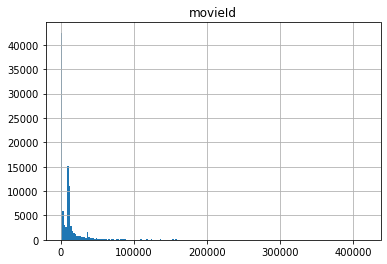

In [37]:
rating_df.hist(['movieId'], bins=200)

We see that many movies have a low amount of reviews. For the benefit of our model, lets find and remove movies with less than 10 reviews:

In [38]:
grouped_rating_df = rating_df[['movieId', 'userId', 'rating']].groupby('movieId').agg({'userId':'count', 'rating':'mean'}).sort_values('rating', ascending=False)
movie_list = grouped_rating_df[grouped_rating_df['userId'] < 10].index.tolist()

rating_df = rating_df[~rating_df['movieId'].isin(movie_list)]
print(rating_df.shape)

(81941, 4)


At this moment we are left with only 82,000 reviews.
To make sure that we can acces the name of every movie, we only select movies that are in the *metadata* file.

In [39]:
movies_in_df = metadata_df[metadata_df.id.isin(grouped_rating_df.index.tolist())]['id'].values

rating_df = rating_df[rating_df['movieId'].isin(movies_in_df)]
print(rating_df.shape)

(81809, 4)


If we look at the amount of unique occurences, we see that the leftover 82,000 reviews have been made by only 671 reviewers. Furthermore, we have reviews for 2200 movies.

In [40]:
print(rating_df.nunique())

userId         671
movieId       2241
rating          10
timestamp    64141
dtype: int64


From the reviews we can find the 10 most reviewed movies present in our metadata

In [41]:
nr_of_ratings = rating_df['movieId'].value_counts()

keys = nr_of_ratings.index.tolist()
reviews = nr_of_ratings.values
for key, review in zip(keys[0:10], reviews[0:10]):   
    print('{:<30s} {:<10s}'.format(metadata_df[metadata_df['id'] == key]['title'].tolist()[0], 'Reviews: ' + str(review)))

Forrest Gump                   Reviews: 341
Pulp Fiction                   Reviews: 324
The Shawshank Redemption       Reviews: 311
The Silence of the Lambs       Reviews: 304
Star Wars                      Reviews: 291
Jurassic Park                  Reviews: 274
The Matrix                     Reviews: 259
Toy Story                      Reviews: 247
Schindler's List               Reviews: 244
Terminator 2: Judgment Day     Reviews: 237


And we can find the 10 highest reviewed movies.

In [42]:
mean_rating_df = rating_df[['movieId', 'userId', 'rating']].groupby('movieId').agg({'userId':'count', 'rating':'mean'}).sort_values('rating', ascending=False)

keys = mean_rating_df.index.tolist()
ratings = mean_rating_df['rating'].tolist()
for key, rating in zip(keys[0:10],ratings[0:10]):   
    print('{:<70s} {:<10s}'.format(metadata_df[metadata_df['id'] == key]['title'].tolist()[0], 'Rating: ' + str(rating)))


The Best Years of Our Lives                                            Rating: 4.636363636363637
Inherit the Wind                                                       Rating: 4.541666666666667
The Godfather                                                          Rating: 4.4875
The Shawshank Redemption                                               Rating: 4.487138263665595
Tom Jones                                                              Rating: 4.458333333333333
Gladiator 1992                                                         Rating: 4.454545454545454
On the Waterfront                                                      Rating: 4.448275862068965
When We Were Kings                                                     Rating: 4.4375
All About Eve                                                          Rating: 4.434210526315789
Ran                                                                    Rating: 4.423076923076923


### SVD
Singular value decomposition (SVD) assumes that a matrix (for example, a $m$ x $n$ matrix) can be decomposed as:

$$ M = U \cdot \Sigma \cdot V^T$$

where $U$ is a $m$ x $m$ matrix, $\Sigma$ is a diagonal matrix of $m$ x $n$, and $V^T$ is a $n$ x $n$ matrix. Matrixes $U$ and $V$ provide information about the rows and columns in the main matrix $M$, which in our case represents the movies and users

In this way, the original matrix can be represented by multiple matrices of a smaller dimension. SVD is therefore, at its core, a form of dimensionality reduction. In our case, this helps as it makes it easier to describe different users and movies and easier to calculate which ones are similar.

Using this information, we can predict the ratings users will give movies they have not yet seen. When a rating is good, this person should get that movie recommended to them.

For a more in depth explanation, please see [this](https://jaketae.github.io/study/svd/) link or [this](https://sifter.org/~simon/journal/20061211.html) explanation by the creator of the SVD method for movie recommendations himself, Simon Funk.

In [43]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale = (0,5))
data = Dataset.load_from_df(rating_df[['userId','movieId','rating']], reader)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [44]:
## Save trained model
model_filename = data_path+'/'+"svd.pickle"
print(">> Starting dump")
dump.dump(model_filename, algo=algo)
print (">> Dump done")
print(model_filename)

>> Starting dump
>> Dump done
/content/gdrive/My Drive/movie-recommendation/svd.pickle


In [45]:
## Load previously saved model
print(">> Loading dump")
_, algo = dump.load(model_filename)
print(">> Loaded dump")

>> Loading dump
>> Loaded dump


In order to retrieve the movie title from the ID, we construct a dataframe

In [46]:
movies = metadata_df[['id', 'title']]
movies = movies.set_index('id')

In [47]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of the SVD algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
          [(movie title, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        movie_name = movies.loc[iid]['title']
        top_n[uid].append((movie_name, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Using our trained model, we can make predictions on ratings for unseen movies for everyone. From there we print the 10 most recommended movies:

In [48]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set -> ANTI_testset.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [movie for (movie, _) in user_ratings])

1 ['The Shawshank Redemption', 'Amélie', 'Ran', 'The Remains of the Day', "Singin' in the Rain", 'The African Queen', 'Roger & Me', 'Rear Window', 'Paris, Texas', "Howl's Moving Castle"]
2 ['Mr. Smith Goes to Washington', 'The Godfather', 'The Treasure of the Sierra Madre', 'Roger & Me', 'Casablanca', 'The Maltese Falcon', 'Memento', 'Lawrence of Arabia', 'Sunset Boulevard', "All the President's Men"]
3 ['The African Queen', 'Lock, Stock and Two Smoking Barrels', 'It Happened One Night', 'Cinema Paradiso', 'Cool Hand Luke', 'Smoke', "Howl's Moving Castle", 'Lawrence of Arabia', 'Harry Potter and the Deathly Hallows: Part 2', 'The Pianist']
4 ['Gandhi', 'The Usual Suspects', "Schindler's List", 'The Shawshank Redemption', 'Run Lola Run', 'A Close Shave', 'Good Will Hunting', 'Life Is Beautiful', 'Catch Me If You Can', 'Fargo']
5 ['Roger & Me', 'Modern Times', 'It Happened One Night', 'Star Wars', 'On the Waterfront', 'The Shawshank Redemption', 'Spirited Away', 'The African Queen', 'Sun

When we compare the ratings of a user with the recommendations the model has predicted, we see that this makes sense.

In [49]:
def printRecommendations(user, k=10):
  user_ratings = rating_df[rating_df['userId'] == user].sort_values('rating', ascending=False)
  print('Ratings by User ' + str(user))
  for index, row in user_ratings.iterrows():
      movie_name = metadata_df[metadata_df['id'] == row['movieId']]['title'].tolist()[0]
      print('{:<50s} {:<10s}'.format(movie_name, 'Rating: ' + str(row['rating'])))
      
  print()
  print('Top-'+ str(k) +' recommendations are:')
  for i in range(k):
    mov, _ = dict(top_n)[user][i]
    print(mov)

user = random.randint(1, 671)
printRecommendations(user)

Ratings by User 338
Schindler's List                                   Rating: 5.0
What's Eating Gilbert Grape                        Rating: 5.0
The Silence of the Lambs                           Rating: 5.0
Terminator 2: Judgment Day                         Rating: 5.0
Mission: Impossible                                Rating: 4.0
The Flintstones                                    Rating: 4.0
The Lion King                                      Rating: 4.0
The Mask                                           Rating: 4.0
The Shawshank Redemption                           Rating: 4.0
Sense and Sensibility                              Rating: 4.0
Addams Family Values                               Rating: 4.0
Ed Wood                                            Rating: 4.0
Don Juan DeMarco                                   Rating: 4.0
Philadelphia                                       Rating: 4.0
The Piano                                          Rating: 4.0
Four Weddings and a Funeral        

### Evaluation


To evaluate our model, first we will look at metrics that show how well our recommendations are . For this, the precision and recall are well defined metrics. The precision calculates the number of correct recommendations as a fraction of all recommendations:

$$ Precision = \frac{(\textrm{Recommended items that are relevant})}{(\textrm{All recommended items})}$$

Where items are deemed to be relevant if their rating is higher than a certain threshold.

Additonally, the recall calculates the number of correct recommendations as a fraction of all recommendations that should be recommended (so both true positives and false negatives).

$$ Recall = \frac{(\textrm{Recommended items that are relevant})}{(\textrm{All relevant items})}$$

From the results, we see that the precision is very high, almost all recommended items are relevant. On the other hand, the recall is much lower, showing that there are more relevant items that we have not recommended. We could think about increasing our value for *k*.

In [50]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [51]:
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
print('Average Precision:',sum(prec for prec in precisions.values()) / len(precisions))
print('Average Recal:',sum(rec for rec in recalls.values()) / len(recalls))

Average Precision: 0.9910581222056631
Average Recal: 0.004703614915721784


Furthermore, to look at absolute error in the prediction of the ratings of our model, we can look at the Root Mean Squared Error of the predictions. In this case we only compare the predictions of the ratings for ratings that are actually in our data.
The root mean squared error takes the error of every prediction, sums it, squares it, and takes the root. 

$$ RMSE = \sqrt{\frac{\sum{(r-\hat{r})^2}}{|R|}}$$

Where: $r$ is the prediction and $\hat{r}$ is the real rating. $|R|$ is the number of ratings in the test set.

Below, we see that our RMSE is 0.64, this means that on average our model makes an error in predicting the rating of 0.64. That is roughly above a 10% error, as the maximum rating is 5.0. This shows that we definitely have a well working model, but that there are still improvements that could be made.

In [52]:
eval_testset = trainset.build_testset()
predictions = algo.test(eval_testset)
print(rmse(predictions))

RMSE: 0.6389
0.6389147906953431


## Conclusion
We have investigated two methods of creating a movie recommendation system. Both succeeded in their respective goals.

#### <span style="color:gray"> Content-based Filtering </span>
In this method, we used the cosine similarity in order to find similar movies. We compared three different vectorization methods. Based on the outputs, the Bag-of-Words and TF-IDF method worked best and predicted the most similar movies. The Word2Vec vectorization method lead to less accurate results.

**Pro's**
- Only needs data on movies in order to make predictions, therefore needs a low amount of memory.

**Con's**
- Will *only* recommend similar movies, people will have less of an incentive to broaden their taste in movies.

<br></br>

#### <span style="color:gray"> Collaborative Filtering </span>
Here, we used Singular value decomposition (SVD) as a method of predicting ratings for movies that users had not seen. The resulting predictions showed that the model made relatively accurate predictions.

**Pro's**
- Can make more diverse recommendations as the method does not focus on a single movie but on all the user's (and other user's) previous reviews.

**Con's**
- Much more data needs to be recorded in order to use this method. All users, movies and reviews need to be stored to be able to make predictions.

<br></br>

In reality, movie recommendation systems used by large companies consist of a mix of both approaches. Additionally, hugely popular content might get a higher place in the recommendations for all users (with a lower regard of the predicted match with the user). 

I hope you enjoyed coming along on this movie recommendation adventure! For other notebooks with machine learning tutorials go [here](https://github.com/bryanlusse/ml-projects)

👋